In [1]:
#匯入檔案
import os
import glob
import pandas as pd

# 指定資料夾路徑
folder_path = r'D:\\py_env_data\\sharker_780\\'

# 遍歷資料夾內的 xlsx 檔案
sharker_files = glob.glob(os.path.join(folder_path, "*.xlsx"))
# print(csv_files)

# 取得檔案名稱
file_names = [os.path.basename(file) for file in sharker_files]

# 讀取檔案內的工作表
df = pd.read_excel(sharker_files[0], sheet_name=None)

# 用於儲存修改後檔案的列表
modified_files = []

# 遍歷每個 Excel 檔案，刪除第二、三列並儲存
for file in sharker_files:  # 從第一個檔案開始遍歷
    # 檢查檔案名稱是否以 'modified_' 開頭
    if os.path.basename(file).startswith('modified_'):
        print(f"跳過檔案: {file} (已處理過)")
        continue  # 跳過已處理的檔案

    # 讀取 Excel 檔案
    df_temp = pd.read_excel(file, sheet_name=None)

    # 遍歷每個工作表
    for sheet_name, sheet_data in df_temp.items():
        print(f"Processing file: {file}, sheet: {sheet_name}, rows: {len(sheet_data)}")

        # 檢查行數是否足夠
        if len(sheet_data) > 2:
            # 刪除第一、二列 (索引 0 和 1)
            sheet_data = sheet_data.drop(index=[0, 1])

        # 檢查刪除後是否還有資料
        if not sheet_data.empty:
            # 儲存修改後的檔案
            output_file = os.path.join(folder_path, f"modified_{os.path.basename(file)}")
            sheet_data.to_excel(output_file, sheet_name=sheet_name, index=False)

            # 將修改後的檔案名稱加入列表
            modified_files.append(output_file)

print("所有檔案已處理並儲存。")
print("修改後的檔案:", modified_files)  # 打印修改後的檔案列表


跳過檔案: D:\\py_env_data\\sharker_780\modified_Z-sine(profiles)_1sweep(change crtl sensor)_20241008.xlsx (已處理過)
跳過檔案: D:\\py_env_data\\sharker_780\modified_Z-sine_1G_20241008.xlsx (已處理過)
Processing file: D:\\py_env_data\\sharker_780\Z-sine(profiles)_summary.xlsx, sheet: Composite.profile(f), rows: 2050
Processing file: D:\\py_env_data\\sharker_780\Z-sine(profiles)_summary.xlsx, sheet: 工作表1, rows: 0
所有檔案已處理並儲存。
修改後的檔案: ['D:\\\\py_env_data\\\\sharker_780\\\\modified_Z-sine(profiles)_summary.xlsx']


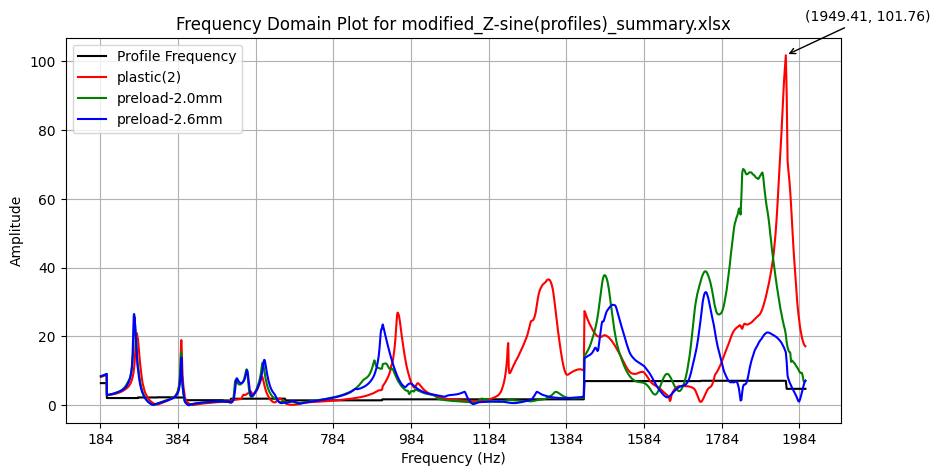

In [15]:
import matplotlib.pyplot as plt
import numpy as np


# df_show =pd.read_excel(modified_files[0])
# df_show.head()

# 遍歷每個修改後的 Excel 檔案
for file in modified_files:
    # 讀取 Excel 檔案，假設資料在第一個工作表
    df = pd.read_excel(file, sheet_name=0)

    # 確保有足夠的欄位
    if df.shape[1] < 8:
        print(f"檔案 {file} 欄位不足，跳過。")
        continue

    # 抓取需要的欄位
    frequency = df.iloc[:, 0]  # 第一欄為 frequency
    profile_frq = df.iloc[:, 1]  # 第二欄為 profile_frq
    sensor_x = df.iloc[:, 6]  # 第七欄為 sensor X
    sensor_y = df.iloc[:, 7]  # 第八欄為 sensor Y
    sensor_z = df.iloc[:, 8]  # 第九欄為 sensor Z

    # # 繪製個別圖表----------------------
    plt.figure(figsize=(10,5))
    plt.plot(frequency, profile_frq, label='Profile Frequency', color='black')
    plt.plot(frequency, sensor_x, label='plastic(2)', color='red')
    plt.plot(frequency, sensor_y, label='preload-2.0mm', color='green')
    plt.plot(frequency, sensor_z, label='preload-2.6mm', color='blue')


    # 找到 sensor_y 的最大值及其對應的頻率
    max_index = np.argmax(sensor_x)
    max_frequency = frequency[max_index]
    max_amplitude = sensor_x[max_index]

    # 在圖上標記最大點
    plt.annotate(f'({max_frequency:.2f}, {max_amplitude:.2f})',
                 xy=(max_frequency, max_amplitude),
                 xytext=(max_frequency + 50, max_amplitude + 10),  # 標籤位置
                 arrowprops=dict(facecolor='black', arrowstyle='->'))

    # 添加標題和標籤
    plt.title(f'Frequency Domain Plot for {os.path.basename(file)}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    #修改X軸刻度
    x_ticks = range(int(frequency.min()), int(frequency.max()) + 10, 200)
    plt.xticks(x_ticks)
    plt.yscale('linear')
    plt.legend()
    plt.grid()

     # 如果需要儲存圖表，可以使用以下代碼
    plt.savefig(os.path.join(folder_path, f'frequency_plot_{os.path.basename(file)}.png'))

    # 顯示圖表
    plt.show()
    #---------------END OF PLOTTING CODE-------------------


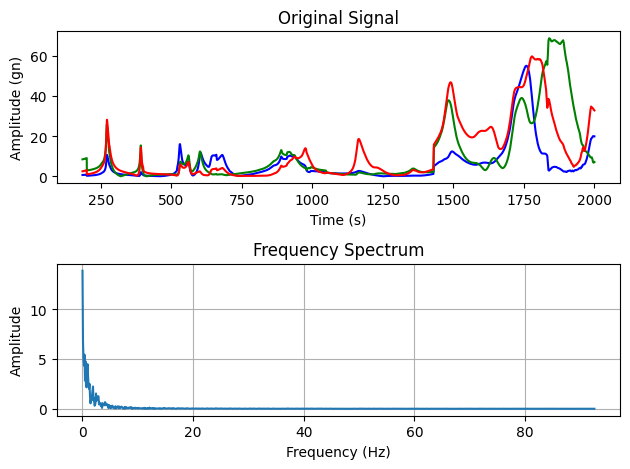

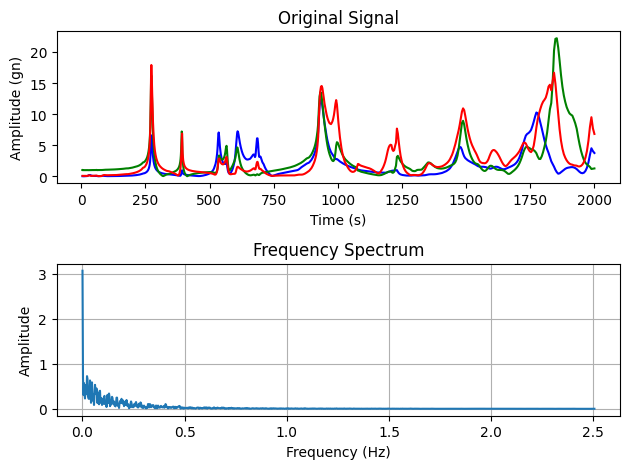

In [25]:
#頻域分析

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import pandas as pd


for file in modified_files:
    # 讀取 Excel 檔案，假設資料在第一個工作表
    df = pd.read_excel(file, sheet_name=0)

    # 確保有足夠的欄位
    if df.shape[1] < 8:
        print(f"檔案 {file} 欄位不足，跳過。")
        continue

    # 提取頻率和振幅數據
    frequency = df.iloc[:, 0]  # 第一欄為頻率
    profile = df.iloc[:, 1]  # 第二欄為振動參數
    amplitude1 = df.iloc[:, 6]  # 第7欄為振幅1
    amplitude2 = df.iloc[:, 7]  # 第8欄為振幅2
    amplitude3 = df.iloc[:, 8]  # 第9欄為振幅3

    # 執行傅立葉變換
    yf = np.fft.fft(amplitude2, n=len(amplitude2))  # 傅立葉變換
    L = len(amplitude2)  # 信號長度
    xf = np.fft.fftfreq(L, d=(1/frequency.iloc[1]))  # 使用第二個頻率計算取樣間隔

    # 繪製原始信號
    plt.subplot(2, 1, 1)
    plt.plot(frequency, profile, label='Profile', color='black')
    plt.plot(frequency, amplitude1, label='Sensor X', color='blue')
    plt.plot(frequency, amplitude2, label='Sensor Y', color='green')
    plt.plot(frequency, amplitude3, label='Sensor Z', color='red')
    plt.title('Original Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (gn)')

    # 繪製頻譜
    plt.subplot(2, 1, 2)
    plt.plot(xf[:L//2], 2.0/L * np.abs(yf[:L//2]))  # 只取正頻率部分
    plt.title('Frequency Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.grid()

    plt.tight_layout()
    plt.show()



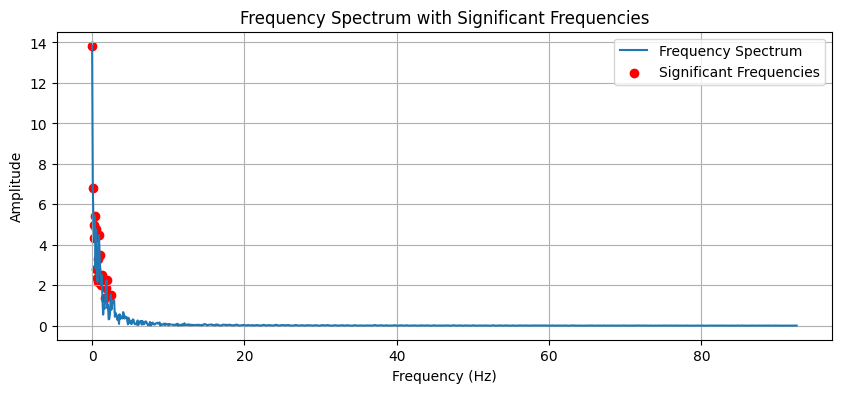

識別出的主要頻率成分（階次）： [0.         0.09043713 0.18087425 0.27131138 0.36174851 0.45218563
 0.54262276 0.63305989 0.72349701 0.81393414 0.90437127 0.9948084
 1.08524552 1.17568265 1.26611978 1.71830541 1.80874254 1.89917966
 2.44180243]


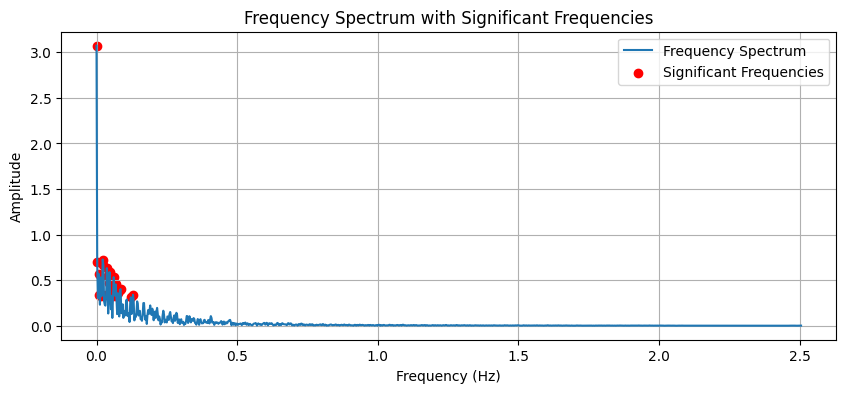

識別出的主要頻率成分（階次）： [0.         0.00244856 0.00734568 0.00979425 0.01469137 0.01713993
 0.01958849 0.02203705 0.02448562 0.03427986 0.03672842 0.03917699
 0.04407411 0.04652267 0.05386836 0.05876548 0.06121404 0.0636626
 0.06611116 0.06855973 0.07590541 0.0832511  0.08569966 0.12242808
 0.12977377]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


# 假設 modified_files 是一個包含檔案路徑的列表
for file in modified_files:
    # 讀取 Excel 檔案，假設資料在第一個工作表
    df = pd.read_excel(file, sheet_name=0)

    # 確保有足夠的欄位
    if df.shape[1] < 9:  # 確保有9欄
        print(f"檔案 {file} 欄位不足，跳過。")
        continue

    # 提取頻率和振幅數據
    frequency = df.iloc[:, 0]  # 第一欄為頻率
    amplitude2 = df.iloc[:, 7]  # 第8欄為振幅2

    # 執行傅立葉變換
    yf = np.fft.fft(amplitude2)
    L = len(amplitude2)  # 信號長度
    xf = np.fft.fftfreq(L, d=(1/frequency.iloc[1]))  # 使用第二個頻率計算取樣間隔

    # 計算幅度
    amplitude_spectrum = 2.0 / L * np.abs(yf[:L//2])

    # 找到主要頻率成分（階次）
    threshold = 0.1 * np.max(amplitude_spectrum)  # 設定閾值
    significant_frequencies = xf[:L//2][amplitude_spectrum > threshold]

    # 繪製頻譜
    plt.figure(figsize=(10, 4))
    plt.plot(xf[:L//2], amplitude_spectrum, label='Frequency Spectrum')
    plt.scatter(significant_frequencies, amplitude_spectrum[amplitude_spectrum > threshold], color='red', label='Significant Frequencies')
    plt.title('Frequency Spectrum with Significant Frequencies')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.legend()
    plt.show()

    # 輸出識別出的階次
    print("識別出的主要頻率成分（階次）：", significant_frequencies)